# Langgraph notebook 2
https://langchain-ai.github.io/langgraph/

Building agents from graphs

In this notebook we first have a smaller model "rephrase" the user command before passing it to a bigger model. We also let the user specify a default config file.

In [8]:
import os
import uuid
from typing import TypedDict, Dict, List, Any, Optional
from dotenv import load_dotenv
from openai import OpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage, BaseMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## Setup

In [9]:
# Define the state
class AgentState(TypedDict):
    messages: List[BaseMessage]
    default_config: str
    processed_command: str
    awaiting_human_input: bool

# Define Opentrons-specific models
class PipetteInfo(BaseModel):
    type: str
    tip_rack: Optional[str] = None

class OpentronsDeckState(BaseModel):
    """Information about the current state of the Opentrons deck."""
    pipettes: Dict[str, PipetteInfo] = Field(default_factory=dict, description="Pipettes attached to the robot, e.g., {'left': 'p300_single', 'right': 'p1000_multi'}")
    labware: Dict[str, str] = Field(default_factory=dict, description="Labware on the deck, e.g., {'1': 'opentrons_24_tuberack_eppendorf_1.5ml_safelock_snapcap'}")
    tip_racks: Dict[str, str] = Field(default_factory=dict, description="Tip racks on the deck, e.g., {'2': 'opentrons_96_tiprack_300ul'}")
    modules: Dict[str, str] = Field(default_factory=dict, description="Modules attached to the deck, e.g., {'7': 'thermocycler'}")

class OpentronsInstructions(BaseModel):
    """Flexible instructions for Opentrons liquid handling tasks."""
    workflow: List[Dict[str, Any]]  # A list of steps in the workflow
    deck_state: OpentronsDeckState

## Define prompts

In [10]:
initial_processing_template = """
Analyze the user's Opentrons liquid handling command and provide a structured summary. Your response should be in YAML format with the following structure:

command: "A clear, specific restatement of the user's command"
task_breakdown:
  - "Step 1: ..."
  - "Step 2: ..."
  - ...
required_resources:
  pipettes: []
  labware: []
  modules: []
  reagents: []
variables_to_specify:
  - "Variable 1: ..."
  - "Variable 2: ..."
  - ...

Focus on identifying all necessary components and variables crucial for task execution. Use Opentrons-specific language in the task breakdown. Only include variables that are critical and not specified in the original command.

Examples:

User input: "Dilute all of the wells on the 96-well plate on deck slot 3 with 10 uL of water from a water container in well 1a of the 24-well metal block on top of the temperature controller. 20 uL tip rack is on deck slot 2 and the 20 uL pipette is mounted on the left side."

Output:
command: "Dilute each well of a 96-well plate with 10 µL of water, using a 20 µL pipette and a temperature-controlled water source"
task_breakdown:
  - "1. Load labware onto the deck: 96-well plate, 24-well aluminum block, and 20 µL tip rack"
  - "2. Load 20 µL single-channel pipette on the left mount"
  - "3. Load temperature module and place 24-well metal block on it"
  - "4. Load liquid (water) to well A1 of the 24-well metal block"
  - "5. For each well in the 96-well plate:"
  - "   a. Pick up a 20 µL tip"
  - "   b. Aspirate 10 µL of water from well A1 of the 24-well block"
  - "   c. Dispense 10 µL into the current well of the 96-well plate"
  - "   d. Drop the used tip"
required_resources:
  pipettes:
    - "20 µL single-channel (left)"
  labware:
    - "96-well plate"
    - "24-well aluminum block"
    - "20 µL tip rack"
  modules:
    - "Temperature module"
  reagents:
    - "Water"
variables_to_specify:
  - "Total volume of water needed for dilution"

User input: "Transfer 5 uL from well A1 to B1 in the same plate and dispose of the tip"

Output:
command: "Transfer 5 µL from well A1 to well B1 within a single plate using a single-channel pipette, then dispose of the tip"
task_breakdown:
  - "1. Load labware onto the deck: plate and tip rack"
  - "2. Load single-channel pipette (≤10 µL capacity)"
  - "3. Pick up a pipette tip"
  - "4. Aspirate 5 µL from well A1 of the plate"
  - "5. Dispense 5 µL into well B1 of the same plate"
  - "6. Drop the used tip in the trash"
required_resources:
  pipettes:
    - "Single-channel pipette (≤10 µL capacity)"
  labware:
    - "Plate"
    - "Tip rack"
  modules: []
  reagents: []
variables_to_specify:
  - "Plate location on deck"
  - "Tip rack location on deck"
  - "Pipette mount position (left or right)"

Provide a similar structured output for the given user input.
"""

get_info_template = """
Your task is to determine if more information is needed to execute the Opentrons liquid handling task. Review the rephrased command, task breakdown, required resources, variables to specify, default configuration, and conversation history.

Analyze the information for:
- Missing required resources
- Unspecified critical variables (e.g., volumes, labware locations, pipette types and positions)
- Compatibility issues between specified labware and pipettes
- Any crucial information gaps that could prevent the protocol from running

If critical information is missing, formulate 1-3 clear, concise questions to gather this information from the user. Focus only on what's absolutely necessary for the protocol to run correctly.

If all critical information is available, use the OpentronsInstructions tool to generate instructions.

Your response should be in one of these two formats:
1. A list of questions, each on a new line, starting with "Q: ". For example:
   Q: What is the specific model of the 96-well plate?
   Q: What is the configuration of the thermocycler plate?

2. Or, if all information is complete, use the OpentronsInstructions tool to structure the information. Here's how to use the tool:

1. Only use the tool when you have gathered ALL necessary information for the task.
2. Structure the information into 'workflow' and 'deck_state' as defined by the tool.
3. For 'workflow', provide a list of discrete steps, each with an 'operation' and relevant parameters.
4. For 'deck_state', include information about pipettes, labware, tip_racks, and modules.
5. If any information is assumed or inferred, clearly state these assumptions before using the tool.
6. Do not include any fields or structures not defined in the OpentronsInstructions tool.

Avoid asking about:
- Exact labware models unless crucial for the protocol
- Minor details that can be assumed based on standard laboratory practices
- Information already provided in the default configuration unless there's a clear conflict

Remember, output ONLY the questions or the tool use instruction, without any additional explanation or analysis.
"""

code_gen_template = """
Based on the following Opentrons workflow and deck state, generate Python code using the Opentrons API:

{instructions}

Ensure the code follows best practices for the Opentrons API, includes proper error handling, and is well-commented for clarity.

Output just the commented code without any explanations or additional text. The user should be able to copy and paste the code into their Python script and run it without any modifications.
"""

## Set up models and chains

In [11]:
initial_processing_prompt = ChatPromptTemplate.from_messages([
    ("system", initial_processing_template),
    ("human", "{input}\n\nDefault Opentrons config:\n{default_config}")
])
initial_processing_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
initial_processing_chain = initial_processing_prompt | initial_processing_model

get_info_prompt = ChatPromptTemplate.from_messages([
    ("system", get_info_template),
    ("human", "Initial command:\n{initial_user_command}\n\nProcessed command:\n{processed_command}\n\nDefault config:\n{default_config}"),
    MessagesPlaceholder(variable_name="follow_up_messages"),
])
get_info_model = ChatOpenAI(model="gpt-4", temperature=0)
get_info_model_with_tool = get_info_model.bind_tools([OpentronsInstructions])
get_info_chain = (
    {
        "initial_user_command": lambda x: x["initial_user_command"],
        "processed_command": lambda x: x["processed_command"],
        "default_config": lambda x: x["default_config"],
        "follow_up_messages": lambda x: x["follow_up_messages"]
    }
    | get_info_prompt
    | get_info_model_with_tool
)

code_gen_prompt = ChatPromptTemplate.from_messages([
    ("system", code_gen_template),
    ("human", "{instructions}")
])
code_gen_model = ChatOpenAI(model="gpt-4", temperature=0)
code_gen_chain = code_gen_prompt | code_gen_model

## Define node functions

In [12]:
def initial_processing_node(state: AgentState):
    processed_command = initial_processing_chain.invoke({
        "input": state["messages"][-1].content,
        "default_config": state["default_config"]
    })
    return {
        "processed_command": processed_command.content,
        "messages": state["messages"] + [AIMessage(content=processed_command.content)]
    }

def get_info_node(state: AgentState):
    initial_user_command = state["messages"][0].content if state["messages"] else ""
    follow_up_messages = state["messages"][2:] if len(state["messages"]) > 2 else []
    
    result = get_info_chain.invoke({
        "initial_user_command": initial_user_command,
        "processed_command": state["processed_command"],
        "default_config": state["default_config"],
        "follow_up_messages": follow_up_messages
    })

    if isinstance(result, AIMessage) and result.tool_calls:
        # If the content is empty, add a default message
        if not result.content:
            result.content = "Using the OpentronsInstructions tool to generate the protocol."
        
        # Handle tool calls
        tool_messages = []
        for tool_call in result.tool_calls:
            if tool_call['name'] == "OpentronsInstructions":
                # Execute the OpentronsInstructions tool
                tool_result = OpentronsInstructions(**tool_call['args'])
                tool_message = ToolMessage(
                    content=str(tool_result),
                    tool_call_id=tool_call['id'],
                    name="OpentronsInstructions"
                )
                tool_messages.append(tool_message)
        
        print(f"\n================================== AI tool call ==================================\n{[msg.content for msg in tool_messages]}\n")
        return {"messages": state["messages"] + [result] + tool_messages, "awaiting_human_input": False}
    elif isinstance(result, (str, AIMessage)):
        new_message = result if isinstance(result, AIMessage) else AIMessage(content=result)
        print(f"\n================================== AI message ==================================\n{new_message.content}\n")
        user_input = input("User (q/Q to quit): ")
        print(f"\n================================== Human message ==================================\n{user_input}\n")
        return {
            "messages": state["messages"] + [new_message, HumanMessage(content=user_input)],
            "awaiting_human_input": False
        }
    else:
        raise ValueError(f"Unexpected result type: {type(result)}")
    
def code_gen_node(state: AgentState):
    instructions = next(msg.content for msg in reversed(state["messages"]) if isinstance(msg, ToolMessage))
    code = code_gen_chain.invoke({"instructions": instructions})
    print(f"\n================================== AI message ==================================\n{code.content}\n")
    return {"messages": state["messages"] + [AIMessage(content=code.content)]}

## Set up the graph

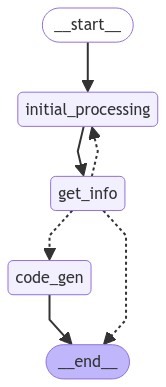

In [13]:
workflow = StateGraph(AgentState)

workflow.add_node("initial_processing", initial_processing_node)
workflow.add_node("get_info", get_info_node)
workflow.add_node("code_gen", code_gen_node)

workflow.add_edge(START, "initial_processing")
workflow.add_edge("initial_processing", "get_info")
workflow.add_conditional_edges(
    "get_info",
    lambda x: "code_gen" if any(isinstance(m, ToolMessage) for m in x["messages"]) else "get_info"
)
workflow.add_edge("code_gen", END)

# Compile the graph
memory = SqliteSaver.from_conn_string(":memory:")
graph = workflow.compile(checkpointer=memory)

# Visualization (if in a Jupyter environment)
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Main execution loop

In [14]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
default_config = """
{
    "pipettes": {
        "left": "p300_single",
        "right": "p10_single"
    },
    "labware": {
    },
    "tip_racks": {
    },
    "modules": {
        "7": "thermocyclerModuleV2"
    }
}
"""

while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    
    print(f"\n================================== Human message ==================================\n{user}\n")

    initial_state = {
        "messages": [HumanMessage(content=user)],
        "default_config": default_config,
        "processed_command": "",
        "awaiting_human_input": False
    }

    output = None
    for output in graph.stream(initial_state, config=config):
        if "messages" in output:
            output["messages"][-1].pretty_print()

    print("\nDone!")


================================== Human message ==================================
Please set the temperature of the thermocycler in deck slot 7 to 90 degC. After it has reached that temp, please transfer 20 uL from well 1A of a 96 well plate in slot 1 to the plate on the thermocycler (same well). Blow out tip and then discard the tip.


================================== AI message ==================================
Q: What type of 96-well plate are you using?
Q: Where are the pipette tips located on the deck?


================================== Human message ==================================
Corning 96 well plate. 300 uL tips in deck slot 2.


================================== AI tool call ==================================
["workflow=[{'operation': 'load_labware', 'labware': 'corning_96_wellplate_360ul_flat', 'slot': '1'}, {'operation': 'load_module', 'module': 'thermocyclerModuleV2', 'slot': '7'}, {'operation': 'set_temperature', 'module': 'thermocyclerModuleV2', 'temperature'